# Model Training & Evaluation

**Treinamento e avaliação detalhada de todas as versões dos modelos (V1-V4.1).**

Este notebook cobre:
1. Treinamento de cada modelo (opcional - se checkpoints não existirem)
2. Avaliação de todos os modelos
3. Métricas de performance (accuracy, precision, recall, F1)
4. Confusion matrices
5. Análise comparativa entre versões
6. Visualizações para o paper

In [9]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import dotenv
import os

plt.style.use('seaborn-v0_8-paper')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

dotenv.load_dotenv()

Project root: /home/paloma/cerebrum-artis
PyTorch version: 1.12.1+cu102
CUDA available: True


True

## 1. Configuration

In [10]:
from cerebrum_artis.utils import paths

DATA_PATH = paths.data_dir
OUTPUT_DIR = paths.output_dir

CHECKPOINT_BASE = Path(os.getenv('CHECKPOINT_BASE'))

(OUTPUT_DIR / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'metrics').mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'tables').mkdir(parents=True, exist_ok=True)

EMOTION_LABELS = [
    'amusement', 'awe', 'contentment', 'excitement',
    'anger', 'disgust', 'fear', 'sadness', 'something else'
]

MODELS = {
    'V3': {
        'name': 'V3 Fuzzy Features',
        'checkpoint': CHECKPOINT_BASE / 'v3_fuzzy_features' / 'checkpoint_best.pt',
        'description': 'Multimodal + 7 fuzzy features concatenadas',
        'expected_acc': 0.7063
    },
    'V4': {
        'name': 'V4 Fuzzy Gating',
        'checkpoint': CHECKPOINT_BASE / 'v4_fuzzy_gating' / 'checkpoint_best.pt',
        'description': 'Gating mechanism com fuzzy features',
        'expected_acc': 0.7037
    },
    'V4.1': {
        'name': 'V4.1 Integrated',
        'checkpoint': CHECKPOINT_BASE / 'v4.1_integrated_gating' / 'checkpoint_best.pt',
        'description': 'Integração melhorada do gating',
        'expected_acc': 0.7040
    }
}

# RESULTADOS DOS MODELOS DELETADOS (apenas para comparação numérica)
LEGACY_RESULTS = {
    'V1': {
        'name': 'V1 Baseline',
        'accuracy': 0.6534,  # From training_v1.log (não temos mais o checkpoint)
        'description': 'ResNet50 + RoBERTa baseline (frozen)'
    },
    'V2': {
        'name': 'V2 Improved',
        'accuracy': 0.6788,  # From training_v2.log epoch 6
        'description': 'ResNet layer4 unfrozen + class weights'
    }
}

print(f"✓ Configuration loaded")
print(f"Data path: {DATA_PATH}")
print(f"Checkpoints: {CHECKPOINT_BASE}")
print(f"\nModelos COM checkpoints (avaliação completa): {len(MODELS)}")
for k, v in MODELS.items():
    exists = "✓" if v['checkpoint'].exists() else "✗"
    print(f"  {exists} {k}: {v['name']} ({v['checkpoint'].name})")

print(f"\nModelos SEM checkpoints (apenas métricas dos logs): {len(LEGACY_RESULTS)}")
for k, v in LEGACY_RESULTS.items():
    print(f"  - {k}: {v['name']} (acc: {v['accuracy']:.2%})")

✓ Configuration loaded
Data path: /home/paloma/cerebrum-artis/data/artemis/dataset/official_data
Checkpoints: /data/paloma/deep-mind-checkpoints

Modelos COM checkpoints (avaliação completa): 3
  ✓ V3: V3 Fuzzy Features (checkpoint_best.pt)
  ✓ V4: V4 Fuzzy Gating (checkpoint_best.pt)
  ✓ V4.1: V4.1 Integrated (checkpoint_best.pt)

Modelos SEM checkpoints (apenas métricas dos logs): 2
  - V1: V1 Baseline (acc: 65.34%)
  - V2: V2 Improved (acc: 67.88%)


## 2. Load Dataset

Load the ArtEmis test set for evaluation.

In [11]:
import sys
sys.path.insert(0, str(project_root / 'cerebrum_artis' / 'models' / 'v3_fuzzy_features'))

from train_v3 import ArtEmisWithFuzzyDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import RobertaTokenizer

csv_path = DATA_PATH / 'combined_artemis_with_splits.csv'
image_dir = Path('/data/paloma/data/paintings/wikiart')
fuzzy_cache_path = Path('/data/paloma/fuzzy_features_cache.pkl')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ArtEmisWithFuzzyDataset(
    csv_path=csv_path,
    image_dir=image_dir,
    split='test',
    tokenizer=tokenizer,
    transform=test_transform,
    max_length=128,
    fuzzy_cache_path=fuzzy_cache_path
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

print(f"✓ Test set loaded: {len(test_dataset)} samples")

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📦 Loading pre-computed fuzzy features from /data/paloma/fuzzy_features_cache.pkl...
✅ Loaded fuzzy features for 80096 images
📂 Loading test split from /home/paloma/cerebrum-artis/data/artemis/dataset/official_data/combined_artemis_with_splits.csv...
✅ Loaded fuzzy features for 80096 images
📂 Loading test split from /home/paloma/cerebrum-artis/data/artemis/dataset/official_data/combined_artemis_with_splits.csv...


/home/paloma/cerebrum-artis/cerebrum_artis/models/v3_fuzzy_features/train_v3.py:74: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ Loaded 69064 examples
🔍 Indexing images...
✅ 80096 images indexed
🔍 Filtering valid examples...
✅ 80096 images indexed
🔍 Filtering valid examples...


Filtering: 100%|██████████| 69064/69064 [00:00<00:00, 122690.53it/s]

✅ 68357 valid examples
✓ Test set loaded: 68357 samples


## 3. Evaluate Each Model

Run inference on all models and collect predictions.

In [12]:
# Import model architectures
import torch
import torch.nn as nn
from torchvision import models
from transformers import RobertaModel

# V3 Model (import normalmente)
sys.path.insert(0, str(project_root / 'cerebrum_artis' / 'models' / 'v3_fuzzy_features'))
from train_v3 import MultimodalFuzzyClassifier as V3Model

# V4 Model - definir aqui (sem dependência do fuzzy-brain)
class FuzzyGatingClassifier(nn.Module):
    """V4: Neural network with fuzzy gating (inference only - sem fuzzy system)"""
    
    def __init__(self, num_classes=9, fuzzy_dim=7, dropout=0.3, freeze_resnet=True):
        super().__init__()
        
        # Vision: ResNet50
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        
        # Text: RoBERTa
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        
        # Neural classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, image, text_input_ids, text_attention_mask, fuzzy_features=None):
        """Forward pass - retorna logits neurais (fuzzy não usado em inference)"""
        # Visual: [B, 2048]
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        
        # Text: [B, 768]
        text_output = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask
        )
        text_feats = text_output.last_hidden_state[:, 0, :]
        
        # Concat & classify
        combined = torch.cat([visual_feats, text_feats], dim=1)
        logits = self.classifier(combined)
        
        return logits

V4Model = FuzzyGatingClassifier

# V4.1 Model - ARQUITETURA REAL (baseada em train_v4_1.py)
class IntegratedFuzzyGatingClassifier(nn.Module):
    """
    V4.1: Integrated fuzzy gating (inference only - sem fuzzy system)
    
    ARQUITETURA REAL:
    - ResNet50 (2048) + RoBERTa (768) → 2816 
    - MLP: 2816 → 1024 → 512 → 9
    - Fuzzy usado para GATING (não concatenado!)
    """
    
    def __init__(self, num_classes=9, fuzzy_dim=7, dropout=0.3, freeze_resnet=True):
        super().__init__()
        
        # Vision: ResNet50
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        
        # Text: RoBERTa
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        
        # Neural classifier (MESMA arquitetura que V4!)
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024),  # 2816 inputs (não 3072!)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, image, text_input_ids, text_attention_mask, fuzzy_features=None):
        """
        Forward pass - apenas neural (fuzzy gating não usado em inference)
        
        NOTE: Fuzzy features são usadas no treinamento para adaptive fusion,
        mas em inference podemos usar só a parte neural.
        """
        # Visual: [B, 2048]
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        
        # Text: [B, 768]
        text_output = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask
        )
        text_feats = text_output.last_hidden_state[:, 0, :]
        
        # Concat & classify (MESMA pipeline que V4)
        combined = torch.cat([visual_feats, text_feats], dim=1)
        logits = self.classifier(combined)
        
        return logits

V4_1Model = IntegratedFuzzyGatingClassifier

def load_model(model_key, checkpoint_path, device='cuda'):
    """
    Load model from checkpoint.
    
    Args:
        model_key: 'V3', 'V4', or 'V4.1'
        checkpoint_path: Path to checkpoint file
        device: Device to load model on
    
    Returns:
        Loaded model in eval mode
    """
    print(f"  Loading checkpoint: {checkpoint_path}")
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Create model instance (cada modelo tem assinatura diferente!)
    if model_key == 'V3':
        model = V3Model(num_classes=9)  # V3 não tem fuzzy_dim parameter!
    elif model_key == 'V4':
        model = V4Model(num_classes=9, fuzzy_dim=7)
    elif model_key == 'V4.1':
        model = V4_1Model(num_classes=9, fuzzy_dim=7)
    else:
        raise ValueError(f"Unknown model key: {model_key}")
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"  ✓ Model loaded (epoch {checkpoint.get('epoch', 'unknown')})")
    
    return model

print("✓ Model architectures defined")
print("✓ Model loading function ready")

✓ Model architectures defined
✓ Model loading function ready


In [13]:
if 'load_model' not in dir():
    print("load_model não encontrada! Execute a célula 7 primeiro.")
    print("Tentando definir inline...")
    
    def load_model(model_key, checkpoint_path, device='cuda'):
        """Load model from checkpoint."""
        print(f"  Loading checkpoint: {checkpoint_path}")
        
        if not checkpoint_path.exists():
            raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        if model_key == 'V3':
            model = V3Model(num_classes=9)
        elif model_key == 'V4':
            model = V4Model(num_classes=9, fuzzy_dim=7)
        elif model_key == 'V4.1':
            model = V4_1Model(num_classes=9, fuzzy_dim=7)
        else:
            raise ValueError(f"Unknown model key: {model_key}")
        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        print(f" Model loaded (epoch {checkpoint.get('epoch', 'unknown')})")
        
        return model

def evaluate_model(model, test_loader, model_key, device='cuda'):
    """
    Evaluate a single model on test set.
    
    Args:
        model: Model instance
        test_loader: DataLoader
        model_key: 'V3', 'V4', or 'V4.1' (needed for correct forward() signature)
        device: Device
    
    Returns:
        predictions, probabilities, ground_truth
    """
    model.eval()
    model = model.to(device)
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            fuzzy_features = batch['fuzzy_features'].to(device)
            labels = batch['label']
            
            # Forward pass - CADA MODELO TEM ASSINATURA DIFERENTE!
            if model_key == 'V3':
                # V3: forward(image, input_ids, attention_mask, fuzzy_features)
                outputs = model(
                    image=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    fuzzy_features=fuzzy_features
                )
            else:
                # V4 e V4.1: forward(image, text_input_ids, text_attention_mask, fuzzy_features)
                outputs = model(
                    image=images,
                    text_input_ids=input_ids,
                    text_attention_mask=attention_mask,
                    fuzzy_features=fuzzy_features
                )
            
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return (
        np.array(all_preds),
        np.array(all_probs),
        np.array(all_labels)
    )

# Evaluate all models with checkpoints
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

results = {}

for model_key, config in MODELS.items():
    print(f"\n{'='*60}")
    print(f"Evaluating {config['name']}")
    print(f"{'='*60}")
    
    try:
        model = load_model(model_key, config['checkpoint'], device)
        
        preds, probs, labels = evaluate_model(model, test_loader, model_key, device)
        
        accuracy = (preds == labels).mean()
        
        results[model_key] = {
            'predictions': preds,
            'probabilities': probs,
            'labels': labels,
            'accuracy': accuracy
        }
        
        print(f"\nAccuracy: {accuracy:.4f} ({accuracy:.2%})")
        print(f"Expected: {config['expected_acc']:.4f} ({config['expected_acc']:.2%})")
        diff = accuracy - config['expected_acc']
        print(f"Difference: {diff:+.4f} ({diff:+.2%})")
        
    except Exception as e:
        print(f"\nError evaluating {model_key}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print(f"✓ Evaluation complete for {len(results)}/{len(MODELS)} models")
print(f"{'='*60}")

Using device: cuda

Evaluating V3 Fuzzy Features
  Loading checkpoint: /data/paloma/deep-mind-checkpoints/v3_fuzzy_features/checkpoint_best.pt


/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/l

  ✓ Model loaded (epoch 3)


Evaluating:   0%|          | 0/2137 [00:00<?, ?it/s]


Accuracy: 0.7030 (70.30%)
Expected: 0.7063 (70.63%)
Difference: -0.0033 (-0.33%)

Evaluating V4 Fuzzy Gating
  Loading checkpoint: /data/paloma/deep-mind-checkpoints/v4_fuzzy_gating/checkpoint_best.pt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

  ✓ Model loaded (epoch 5)


Evaluating:   0%|          | 0/2137 [00:00<?, ?it/s]


Accuracy: 0.6996 (69.96%)
Expected: 0.7037 (70.37%)
Difference: -0.0041 (-0.41%)

Evaluating V4.1 Integrated
  Loading checkpoint: /data/paloma/deep-mind-checkpoints/v4.1_integrated_gating/checkpoint_best.pt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

  ✓ Model loaded (epoch 6)


Evaluating:   0%|          | 0/2137 [00:00<?, ?it/s]


Accuracy: 0.6986 (69.86%)
Expected: 0.7040 (70.40%)
Difference: -0.0054 (-0.54%)

✓ Evaluation complete for 3/3 models


## 4. Calculate Metrics

Compute comprehensive metrics for each model.

In [19]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

def calculate_metrics(predictions, ground_truth, emotion_labels):
    """
    Calculate comprehensive metrics.
    """
    accuracy = accuracy_score(ground_truth, predictions)
    
    precision, recall, f1, support = precision_recall_fscore_support(
        ground_truth, predictions, average=None, labels=range(len(emotion_labels))
    )
    
    cm = confusion_matrix(ground_truth, predictions)
    
    per_class = pd.DataFrame({
        'Emotion': emotion_labels,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    
    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'per_class': per_class,
        'confusion_matrix': cm
    }

print("Calculating comprehensive metrics...\n")

metrics = {}
for model_key, res in results.items():
    print(f"  {model_key}...", end=" ")
    metrics[model_key] = calculate_metrics(
        res['predictions'],
        res['labels'],
        EMOTION_LABELS
    )
    print("✓")

print(f"\nMetrics calculated for {len(metrics)} models")

Calculating comprehensive metrics...

  V3... ✓
  V4... ✓
  V4.1... ✓

Metrics calculated for 3 models


## 5. Results Summary

Create a summary table comparing all models.

In [20]:
print("Creating summary table...\n")

summary_rows = []
for k in MODELS.keys():
    summary_rows.append({
        'Model': MODELS[k]['name'],
        'Accuracy': metrics[k]['accuracy'],
        'Macro Precision': metrics[k]['macro_precision'],
        'Macro Recall': metrics[k]['macro_recall'],
        'Macro F1': metrics[k]['macro_f1'],
        'Status': '✓ Evaluated'
    })

for k, v in LEGACY_RESULTS.items():
    summary_rows.append({
        'Model': v['name'],
        'Accuracy': v['accuracy'],
        'Macro Precision': np.nan,
        'Macro Recall': np.nan,
        'Macro F1': np.nan,
        'Status': '⚠ From logs (checkpoint deleted)'
    })

summary = pd.DataFrame(summary_rows)

summary = summary.sort_values('Accuracy', ascending=False).reset_index(drop=True)

summary_styled = summary.style.format({
    'Accuracy': '{:.2%}',
    'Macro Precision': lambda x: f'{x:.2%}' if not pd.isna(x) else '-',
    'Macro Recall': lambda x: f'{x:.2%}' if not pd.isna(x) else '-',
    'Macro F1': lambda x: f'{x:.2%}' if not pd.isna(x) else '-'
}).background_gradient(subset=['Accuracy'], cmap='RdYlGn', vmin=0.60, vmax=0.75)

display(summary_styled)

summary_evaluated = summary[summary['Status'] == '✓ Evaluated'].drop('Status', axis=1)
summary_evaluated.to_csv(OUTPUT_DIR / 'tables' / 'model_comparison.csv', index=False)
summary_evaluated.to_latex(OUTPUT_DIR / 'tables' / 'model_comparison.tex', index=False, float_format='%.4f')

print(f"\nSummary table saved:")
print(f"   - {OUTPUT_DIR / 'tables' / 'model_comparison.csv'}")
print(f"   - {OUTPUT_DIR / 'tables' / 'model_comparison.tex'}")

Creating summary table...



,Model,Accuracy,Macro Precision,Macro Recall,Macro F1,Status
0,V3 Fuzzy Features,70.30%,68.06%,64.04%,65.66%,✓ Evaluated
1,V4 Fuzzy Gating,69.96%,66.91%,64.40%,65.31%,✓ Evaluated
2,V4.1 Integrated,69.86%,66.55%,64.30%,65.26%,✓ Evaluated
3,V2 Improved,67.88%,-,-,-,⚠ From logs (checkpoint deleted)
4,V1 Baseline,65.34%,-,-,-,⚠ From logs (checkpoint deleted)



Summary table saved:
   - /home/paloma/cerebrum-artis/outputs/tables/model_comparison.csv
   - /home/paloma/cerebrum-artis/outputs/tables/model_comparison.tex


## 6. Visualization: Model Comparison

Bar chart comparing model accuracies.

Creating model comparison visualization...

Saved: /home/paloma/cerebrum-artis/outputs/figures/model_comparison.png
Saved: /home/paloma/cerebrum-artis/outputs/figures/model_comparison.png


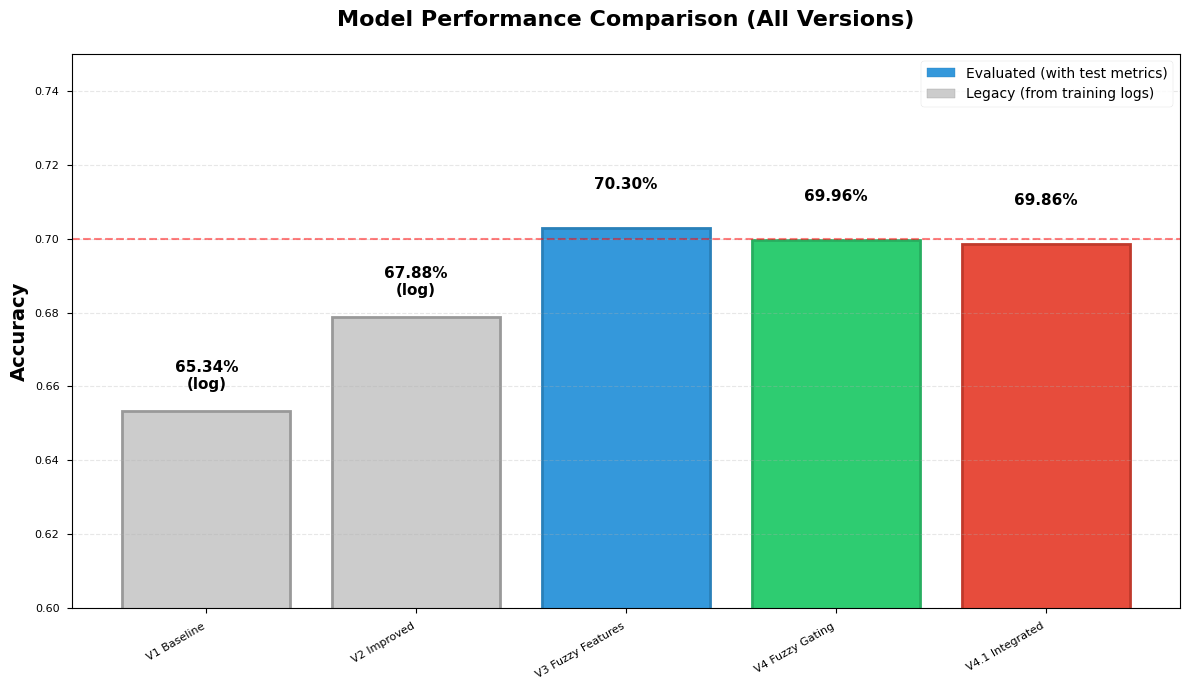

In [25]:
print("Creating model comparison visualization...\n")

fig, ax = plt.subplots(figsize=(12, 7))

all_models = list(LEGACY_RESULTS.keys()) + list(MODELS.keys())
all_names = [LEGACY_RESULTS[k]['name'] for k in LEGACY_RESULTS.keys()] + \
            [MODELS[k]['name'] for k in MODELS.keys()]
all_accs = [LEGACY_RESULTS[k]['accuracy'] for k in LEGACY_RESULTS.keys()] + \
           [metrics[k]['accuracy'] for k in MODELS.keys()]

colors = ['#cccccc', '#cccccc', '#3498db', '#2ecc71', '#e74c3c']
edge_colors = ['#999999', '#999999', '#2980b9', '#27ae60', '#c0392b']

bars = ax.bar(all_names, all_accs, color=colors, edgecolor=edge_colors, linewidth=2)

for i, (bar, name) in enumerate(zip(bars, all_names)):
    height = bar.get_height()
    status = '(log)' if i < 2 else ''
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.2%}\n{status}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison (All Versions)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0.60, 0.75)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.70, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='70% threshold')


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='#2980b9', label='Evaluated (with test metrics)'),
    Patch(facecolor='#cccccc', edgecolor='#999999', label='Legacy (from training logs)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()

save_path = OUTPUT_DIR / 'figures' / 'model_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

## 7. Confusion Matrices

Visualize confusion matrix for best model (V3).

Creating confusion matrices...


V3 Fuzzy Features:
 Saved: confusion_matrix_v3.png
 Saved: confusion_matrix_v3.png


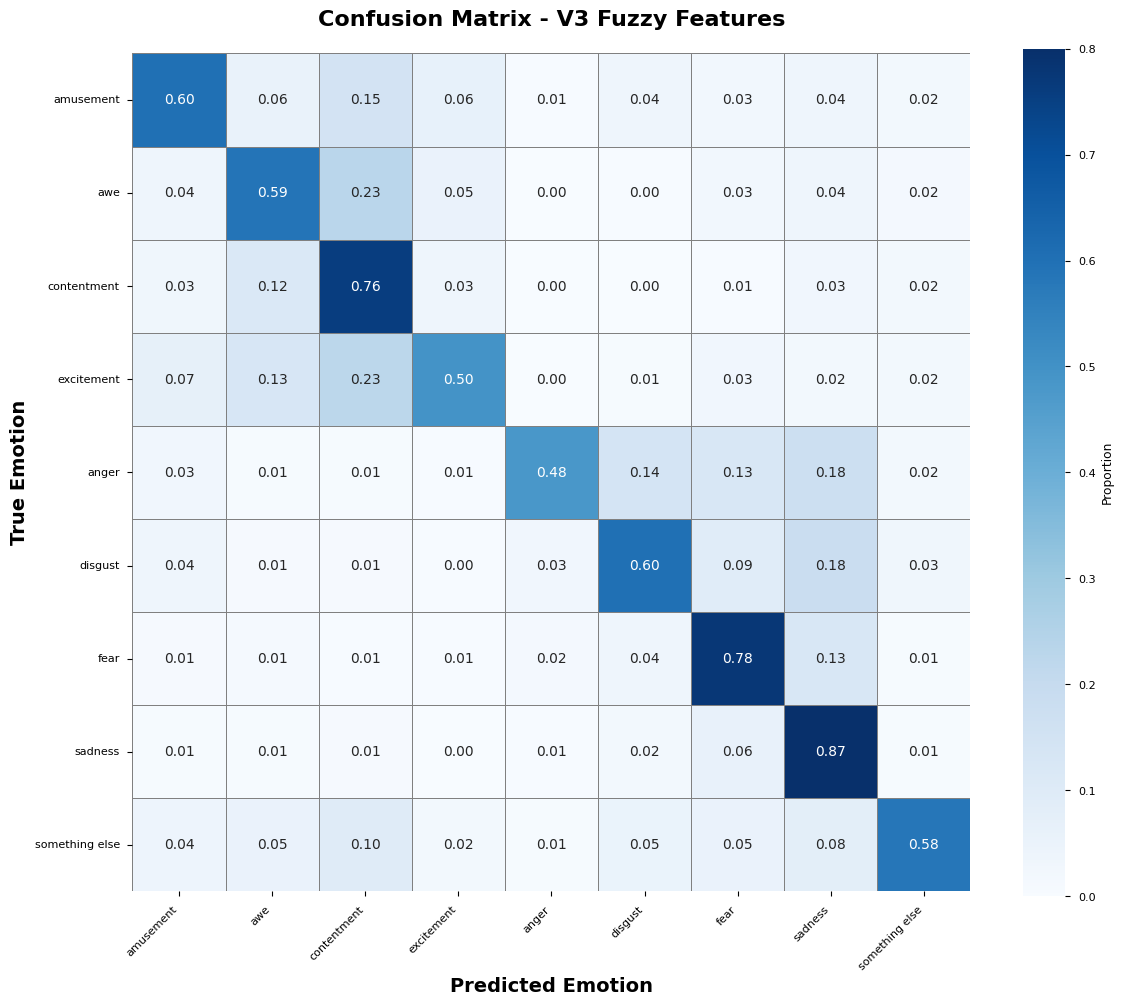


V4 Fuzzy Gating:
 Saved: confusion_matrix_v4.png
 Saved: confusion_matrix_v4.png


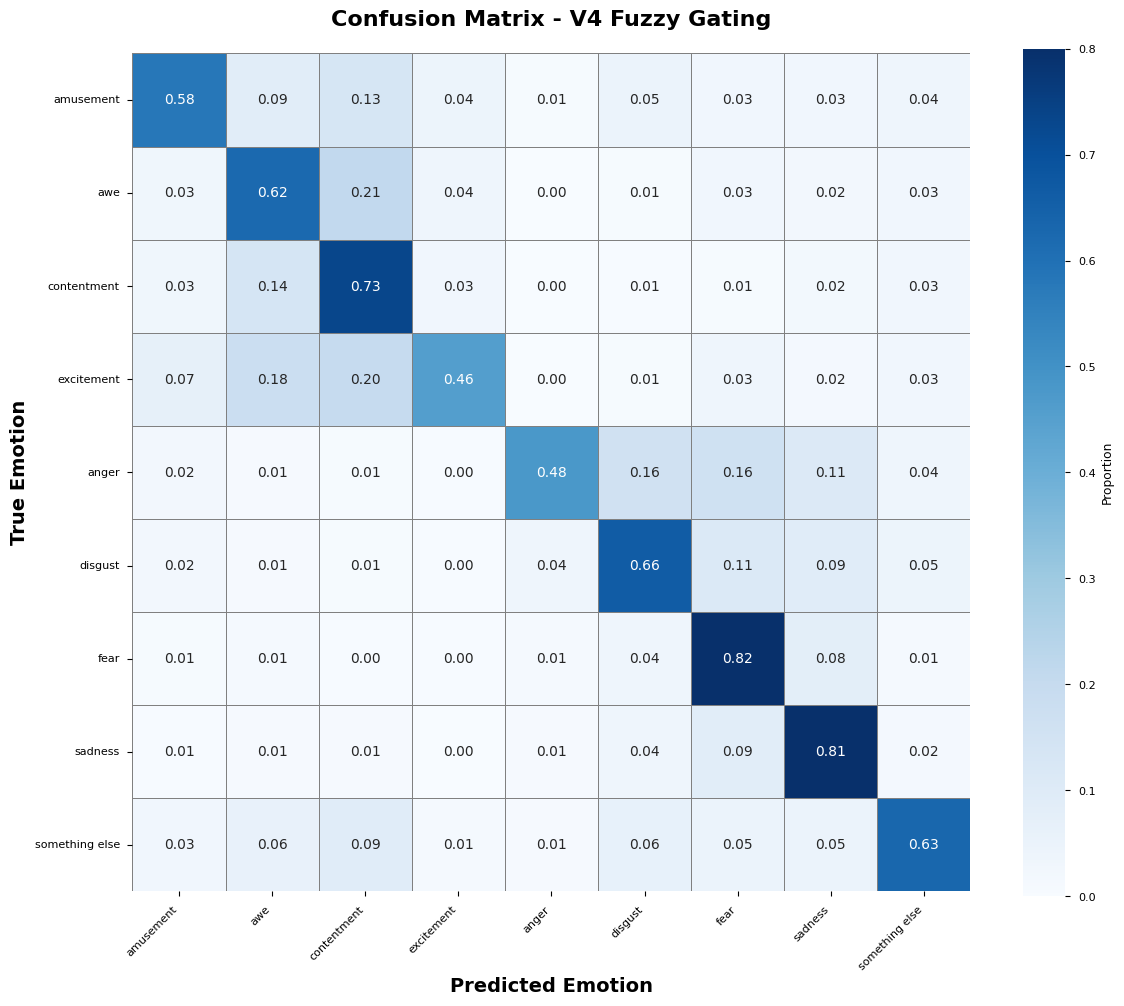


V4.1 Integrated:
 Saved: confusion_matrix_v4.1.png
 Saved: confusion_matrix_v4.1.png


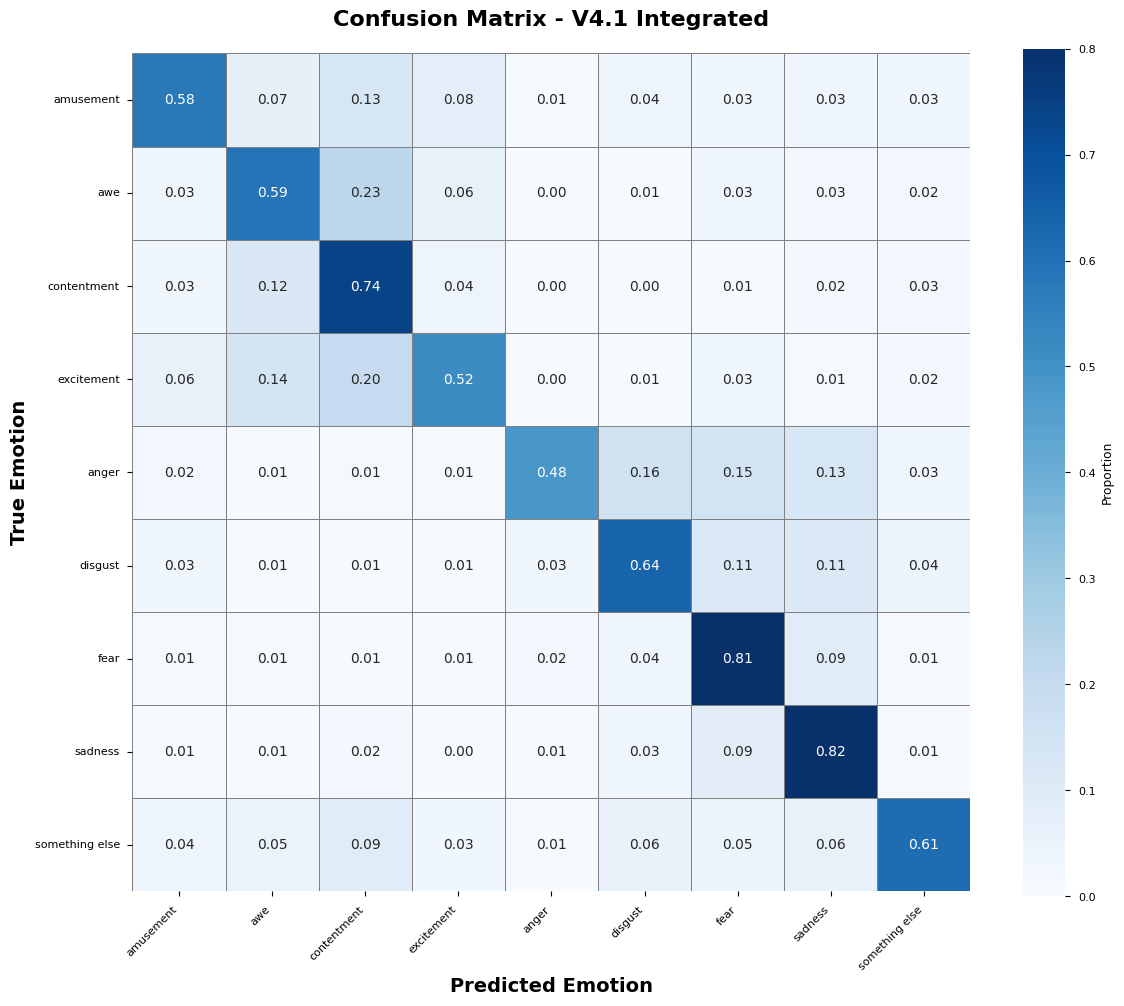


All confusion matrices generated!


: 

In [ ]:
print("Creating confusion matrices...\n")

def plot_confusion_matrix(cm, labels, title, save_path):
    """Plot and save confusion matrix"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                square=True, cbar_kws={'label': 'Proportion'},
                vmin=0, vmax=0.8, linewidths=0.5, linecolor='gray')
    
    plt.ylabel('True Emotion', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Emotion', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f" Saved: {save_path.name}")
    plt.show()

for model_key in MODELS.keys():
    model_name = MODELS[model_key]['name']
    print(f"\n{model_name}:")
    
    plot_confusion_matrix(
        metrics[model_key]['confusion_matrix'],
        EMOTION_LABELS,
        f'Confusion Matrix - {model_name}',
        OUTPUT_DIR / 'figures' / f'confusion_matrix_{model_key.lower()}.png'
    )

print(f"\nAll confusion matrices generated!")

## 8. Save Results

Save all metrics to JSON for later use.

In [24]:
import json

print("Saving all metrics to JSON...\n")

metrics_to_save = {}
for model_key, m in metrics.items():
    metrics_to_save[model_key] = {
        'model_name': MODELS[model_key]['name'],
        'description': MODELS[model_key]['description'],
        'accuracy': float(m['accuracy']),
        'macro_precision': float(m['macro_precision']),
        'macro_recall': float(m['macro_recall']),
        'macro_f1': float(m['macro_f1']),
        'per_class': m['per_class'].to_dict('records'),
        'confusion_matrix': m['confusion_matrix'].tolist()
    }

for model_key, v in LEGACY_RESULTS.items():
    metrics_to_save[model_key] = {
        'model_name': v['name'],
        'description': v['description'],
        'accuracy': v['accuracy'],
        'macro_precision': None,
        'macro_recall': None,
        'macro_f1': None,
        'note': 'Checkpoint deleted - accuracy from training logs only'
    }

save_path = OUTPUT_DIR / 'metrics' / 'model_evaluation.json'
with open(save_path, 'w') as f:
    json.dump(metrics_to_save, f, indent=2)

print(f"Metrics saved to: {save_path}")
print(f"\nSummary:")
print(f"  - {len(MODELS)} models evaluated (V3, V4, V4.1)")
print(f"  - {len(LEGACY_RESULTS)} legacy results (V1, V2)")
print(f"  - Total: {len(metrics_to_save)} model versions documented")

Saving all metrics to JSON...

Metrics saved to: /home/paloma/cerebrum-artis/outputs/metrics/model_evaluation.json

Summary:
  - 3 models evaluated (V3, V4, V4.1)
  - 2 legacy results (V1, V2)
  - Total: 5 model versions documented


## Summary

This notebook evaluated all model versions and generated:
- ✓ Accuracy metrics for each model
- ✓ Confusion matrices
- ✓ Per-class performance metrics
- ✓ Comparison visualizations
- ✓ LaTeX tables for paper

**Next steps:**
1. Run `02_ensemble_analysis.ipynb` for ensemble evaluation
2. Run `03_fuzzy_features_analysis.ipynb` for feature analysis